<a href="https://colab.research.google.com/github/EmanAgada/Data-Analysis-Portfolio/blob/main/Masters_Project_Artefact.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mplsoccer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.4/86.4 kB 2.6 MB/s eta 0:00:00


In [ ]:
import json
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from mplsoccer import Pitch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Masking



## Load Tracking Data

In [ ]:
EvEng = pd.read_csv('events_England.csv')


In [ ]:
EvEng.isnull().sum()

eventId            0
subEventName    1558
tags               0
playerId           0
positions          0
matchId            0
eventName          0
teamId             0
matchPeriod        0
eventSec           0
subEventId      1558
id                 0
dtype: int64

In [ ]:
EvEng.head()

eventId subEventName            tags  playerId  \
0        8  Simple pass  [{'id': 1801}]     25413   
1        8    High pass  [{'id': 1801}]    370224   
2        8    Head pass  [{'id': 1801}]      3319   
3        8    Head pass  [{'id': 1801}]    120339   
4        8  Simple pass  [{'id': 1801}]    167145   

                                  positions  matchId eventName  teamId  \
0  [{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]  2499719      Pass    1609   
1  [{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]  2499719      Pass    1609   
2  [{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]  2499719      Pass    1609   
3  [{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]  2499719      Pass    1609   
4  [{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]  2499719      Pass    1609   

  matchPeriod   eventSec  subEventId         id  
0          1H   2.758649        85.0  177959171  
1          1H   4.946850        83.0  177959172  
2          1H   6.542188        82.0  177959173  
3          1H   8.143395        82.0  177959174  
4          1H  10.302366        85.0  177959175

# Seperating the position values into start and end.

The position column contains string values as a list of dictionaries. The 'y' and 'x' values denote the position of the player, the start and end point of the event.

In [ ]:
# Fill missing 'positions' values with empty lists
#EvEng['positions'] = EvEng['positions'].fillna('[]')

EvEng['positions'] = EvEng['positions'].apply(ast.literal_eval)

EvEng['start_position'] = EvEng['positions'].apply(lambda pos: pos[0] if len(pos) > 0 else None)
EvEng['end_position'] = EvEng['positions'].apply(lambda pos: pos[1] if len(pos) > 1 else None )

display(EvEng.head(5))

eventId subEventName            tags  playerId  \
0        8  Simple pass  [{'id': 1801}]     25413   
1        8    High pass  [{'id': 1801}]    370224   
2        8    Head pass  [{'id': 1801}]      3319   
3        8    Head pass  [{'id': 1801}]    120339   
4        8  Simple pass  [{'id': 1801}]    167145   

                                  positions  matchId eventName  teamId  \
0  [{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]  2499719      Pass    1609   
1  [{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]  2499719      Pass    1609   
2  [{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]  2499719      Pass    1609   
3  [{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]  2499719      Pass    1609   
4  [{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]  2499719      Pass    1609   

  matchPeriod   eventSec  subEventId         id      start_position  \
0          1H   2.758649        85.0  177959171  {'y': 49, 'x': 49}   
1          1H   4.946850        83.0  177959172  {'y': 78, 'x': 31}   
2          1H   6.542188        82.0  177959173  {'y': 75, 'x': 51}   
3          1H   8.143395        82.0  177959174  {'y': 71, 'x': 35}   
4          1H  10.302366        85.0  177959175  {'y': 95, 'x': 41}   

         end_position  
0  {'y': 78, 'x': 31}  
1  {'y': 75, 'x': 51}  
2  {'y': 71, 'x': 35}  
3  {'y': 95, 'x': 41}  
4  {'y': 88, 'x': 72}

In [ ]:
# further seperating into x and y values

EvEng['start_x'] = EvEng['start_position'].apply(lambda pos: pos.get('x') if pos else None )
EvEng['start_y'] = EvEng['start_position'].apply(lambda pos: pos.get('y') if pos else None )
EvEng['end_x'] = EvEng['end_position'].apply(lambda pos: pos.get('x') if pos else None )
EvEng['end_y'] = EvEng['end_position'].apply(lambda pos: pos.get('y') if pos else None )

EvEng.head(5)

eventId subEventName            tags  playerId  \
0        8  Simple pass  [{'id': 1801}]     25413   
1        8    High pass  [{'id': 1801}]    370224   
2        8    Head pass  [{'id': 1801}]      3319   
3        8    Head pass  [{'id': 1801}]    120339   
4        8  Simple pass  [{'id': 1801}]    167145   

                                  positions  matchId eventName  teamId  \
0  [{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]  2499719      Pass    1609   
1  [{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]  2499719      Pass    1609   
2  [{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]  2499719      Pass    1609   
3  [{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]  2499719      Pass    1609   
4  [{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]  2499719      Pass    1609   

  matchPeriod   eventSec  subEventId         id      start_position  \
0          1H   2.758649        85.0  177959171  {'y': 49, 'x': 49}   
1          1H   4.946850        83.0  177959172  {'y': 78, 'x': 31}   
2          1H   6.542188        82.0  177959173  {'y': 75, 'x': 51}   
3          1H   8.143395        82.0  177959174  {'y': 71, 'x': 35}   
4          1H  10.302366        85.0  177959175  {'y': 95, 'x': 41}   

         end_position  start_x  start_y  end_x  end_y  
0  {'y': 78, 'x': 31}       49       49   31.0   78.0  
1  {'y': 75, 'x': 51}       31       78   51.0   75.0  
2  {'y': 71, 'x': 35}       51       75   35.0   71.0  
3  {'y': 95, 'x': 41}       35       71   41.0   95.0  
4  {'y': 88, 'x': 72}       41       95   72.0   88.0

In [ ]:
#drop the useless columns.

EvEngn = EvEng.drop(columns=['positions', 'start_position', 'end_position'])

# Scale coordinates to mplsoccer StatsBomb pitch dimensions (120x80)
EvEngn['start_x'] = EvEngn['start_x'] * 1.2
EvEngn['start_y'] = EvEngn['start_y'] * 0.8
EvEngn['end_x'] = EvEngn['end_x'] * 1.2
EvEngn['end_y'] = EvEngn['end_y'] * 0.8


EvEngn.head(5)

eventId subEventName            tags  playerId  matchId eventName  teamId  \
0        8  Simple pass  [{'id': 1801}]     25413  2499719      Pass    1609   
1        8    High pass  [{'id': 1801}]    370224  2499719      Pass    1609   
2        8    Head pass  [{'id': 1801}]      3319  2499719      Pass    1609   
3        8    Head pass  [{'id': 1801}]    120339  2499719      Pass    1609   
4        8  Simple pass  [{'id': 1801}]    167145  2499719      Pass    1609   

  matchPeriod   eventSec  subEventId         id  start_x  start_y  end_x  \
0          1H   2.758649        85.0  177959171     58.8     39.2   37.2   
1          1H   4.946850        83.0  177959172     37.2     62.4   61.2   
2          1H   6.542188        82.0  177959173     61.2     60.0   42.0   
3          1H   8.143395        82.0  177959174     42.0     56.8   49.2   
4          1H  10.302366        85.0  177959175     49.2     76.0   86.4   

   end_y  
0   62.4  
1   60.0  
2   56.8  
3   76.0  
4   70.4

## Compute Pass Distance and angles

In [ ]:
EvEngn['dx'] = EvEngn['end_x'] - EvEngn['start_x']
EvEngn['dy'] = EvEngn['end_y'] - EvEngn['start_y']

# df = compute_distance_to_ball(df)

In [ ]:
EvEngn['dist'] = np.sqrt(EvEngn['dx']**2 + EvEngn['dy']**2)
EvEngn['angle'] = np.degrees(np.arctan2(EvEngn['dy'], EvEngn['dx']))


In [ ]:
EvEngn.head()

eventId subEventName            tags  playerId  matchId eventName  teamId  \
0        8  Simple pass  [{'id': 1801}]     25413  2499719      Pass    1609   
1        8    High pass  [{'id': 1801}]    370224  2499719      Pass    1609   
2        8    Head pass  [{'id': 1801}]      3319  2499719      Pass    1609   
3        8    Head pass  [{'id': 1801}]    120339  2499719      Pass    1609   
4        8  Simple pass  [{'id': 1801}]    167145  2499719      Pass    1609   

  matchPeriod   eventSec  subEventId         id  start_x  start_y  end_x  \
0          1H   2.758649        85.0  177959171     58.8     39.2   37.2   
1          1H   4.946850        83.0  177959172     37.2     62.4   61.2   
2          1H   6.542188        82.0  177959173     61.2     60.0   42.0   
3          1H   8.143395        82.0  177959174     42.0     56.8   49.2   
4          1H  10.302366        85.0  177959175     49.2     76.0   86.4   

   end_y    dx    dy       dist       angle  
0   62.4 -21.6  23.2  31.698580  132.954592  
1   60.0  24.0  -2.4  24.119701   -5.710593  
2   56.8 -19.2  -3.2  19.464840 -170.537678  
3   76.0   7.2  19.2  20.505609   69.443955  
4   70.4  37.2  -5.6  37.619144   -8.560890

# Creating the input for sequence modelling

#Labelling for both players and teams

In [ ]:
# Fill missing values in relevant columns before grouping and ranking
EvEngn['playerId'] = EvEngn['playerId'].fillna(-1)
EvEngn['matchId'] = EvEngn['matchId'].fillna(-1)
EvEngn['teamId'] = EvEngn['teamId'].fillna(-1)


# Group by game and team to get unique players
grouped_players = EvEngn.groupby(['matchId', 'teamId'])['playerId'].unique().reset_index()

# Create a dictionary to store unique labels for each teamId
team_labels = {}
current_label = 1

# Iterate through the unique teamIds and assign a unique label
for team_id in grouped_players['teamId'].unique():
  team_labels[team_id] = f'Team_{current_label}'
  current_label += 1

# Create a new column 'team_label' in the original DataFrame
EvEngn['team_label'] = EvEngn['teamId'].map(team_labels)

# Create a new column 'player_label' based on the order of appearance within each team in each game
EvEngn['player_label'] = EvEngn.groupby(['matchId', 'teamId'])['playerId'].rank(method='dense').astype(int)

# Create a new column 'match_label'
match_labels = {match_id: f'Match_{i+1}' for i, match_id in enumerate(EvEngn['matchId'].unique())}
EvEngn['match_label'] = EvEngn['matchId'].map(match_labels)


# You can now see the new columns in the DataFrame
print(EvEngn[['matchId', 'match_label', 'teamId', 'team_label', 'playerId', 'player_label']].head())

   matchId match_label  teamId team_label  playerId  player_label
0  2499719     Match_1    1609     Team_1     25413            10
1  2499719     Match_1    1609     Team_1    370224            15
2  2499719     Match_1    1609     Team_1      3319             2
3  2499719     Match_1    1609     Team_1    120339            13
4  2499719     Match_1    1609     Team_1    167145            14


In [ ]:
EvEngn.to_csv('EvEngn.csv')

In [ ]:
# Create a formation identifier using team shape snapshots
formation_data = EvEngn[EvEngn['eventSec'] < 60].copy()
formation_data = formation_data[['match_label', 'team_label', 'player_label', 'start_x', 'start_y']]
formation_data = formation_data.groupby(['match_label', 'team_label', 'player_label']).mean().reset_index()

# Encode team formations for classification
formation_data['label'] = formation_data['team_label'].astype(str) + "_" + formation_data['match_label'].astype(str)
label_encoder = LabelEncoder()
formation_data['formation_class'] = label_encoder.fit_transform(formation_data['label'])

X_form = formation_data[['start_x', 'start_y']].values.reshape(-1, 1, 2)
y_form = tf.keras.utils.to_categorical(formation_data['formation_class'])

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_form, y_form, test_size=0.2, random_state=42)

In [ ]:
X = EvEngn.select_dtypes(include=np.number).drop(['start_x', 'start_y'], axis=1)
y = EvEngn[['start_x', 'start_y']]

# Split data into training and validation sets
X_train2, X_val2, y_train2, y_val2 = train_test_split(X, y, test_size=0.2, random_state=42)

#Training the Deep Learning Models

In [ ]:
#LSTM MODEL

model_lstm = Sequential([
    Masking(mask_value=0.0, input_shape=(1, 2)),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_form.shape[1], activation='softmax')
])

model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_lstm = model_lstm.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1, validation_data=(X_val, y_val))

Epoch 1/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.0018 - loss: 6.6443 - val_accuracy: 0.0000e+00 - val_loss: 6.6465
Epoch 2/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0013 - loss: 6.6005 - val_accuracy: 0.0014 - val_loss: 6.6955
Epoch 3/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0025 - loss: 6.5106 - val_accuracy: 7.0572e-04 - val_loss: 6.7319
Epoch 4/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0027 - loss: 6.4568 - val_accuracy: 0.0000e+00 - val_loss: 6.8361
Epoch 5/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0059 - loss: 6.3908 - val_accuracy: 7.0572e-04 - val_loss: 6.8748
Epoch 6/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.0062 - loss: 6.3400 - val_accuracy: 7.0572e-04 - val_loss: 6.9256
Epoch 7/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0059 - loss: 6.2994 - val_accuracy: 0.0000e+00 - val_loss: 6.9496
Epoch 8/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0062 - loss: 6

In [ ]:
#LSTM MODEL2

model_lstm2 = Sequential([
    LSTM(64, input_shape=(X_train2.shape[1], 1)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_train2.shape[1])
])

model_lstm2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history_lstm2 = model_lstm2.fit(X_train2, y_train2, epochs=1, batch_size=16, verbose=1, validation_data=(X_val2, y_val2))

32158/32158 ━━━━━━━━━━━━━━━━━━━━ 224s 7ms/step - accuracy: 0.6811 - loss: nan - val_accuracy: 0.6810 - val_loss: nan


In [ ]:
from tensorflow.keras.layers import Input

#CNN model
model_cnn = Sequential([
    Input(shape=(1, 2)),
    Conv1D(64, kernel_size=1, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_form.shape[1], activation='softmax')
])
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_cnn = model_cnn.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1, validation_data=(X_val, y_val))

Epoch 1/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 9.4385e-04 - loss: 7.4124 - val_accuracy: 7.0572e-04 - val_loss: 6.6438
Epoch 2/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0027 - loss: 6.6264 - val_accuracy: 7.0572e-04 - val_loss: 6.6557
Epoch 3/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0018 - loss: 6.6170 - val_accuracy: 7.0572e-04 - val_loss: 6.6629
Epoch 4/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0015 - loss: 6.6037 - val_accuracy: 0.0021 - val_loss: 6.6663
Epoch 5/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0033 - loss: 6.6002 - val_accuracy: 0.0014 - val_loss: 6.6743
Epoch 6/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 6.5433e-04 - loss: 6.5873 - val_accuracy: 0.0014 - val_loss: 6.7117
Epoch 7/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0020 - loss: 6.5863 - val_accuracy: 7.0572e-04 - val_loss: 6.7119
Epoch 8/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0015 - loss: 6

#Evaluation of the models

In [ ]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=False)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(f"{name} Classification Report:\n{report}")
    return acc

acc_lstm = evaluate_model(model_lstm, X_val, y_val, "LSTM")
acc_cnn = evaluate_model(model_cnn, X_val, y_val, "Temporal CNN")

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

LSTM Accuracy: 0.0000
LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       3.0
           1       0.00      0.00      0.00       1.0
           2       0.00      0.00      0.00       4.0
           3       0.00      0.00      0.00       2.0
           4       0.00      0.00      0.00       1.0
           5       0.00      0.00      0.00       2.0
           6       0.00      0.00      0.00       2.0
           7       0.00      0.00      0.00       3.0
           8       0.00      0.00      0.00       2.0
           9       0.00      0.00      0.00       1.0
          10       0.00      0.00      0.00       1.0
          11       0.00      0.00      0.00       1.0
          13       0.00      0.00      0.00       3.0
          14       0.00      0.00      0.00       1.0
          15       0.00      0.00      0.00       1.0
          16       0.00      0.00      0.00  

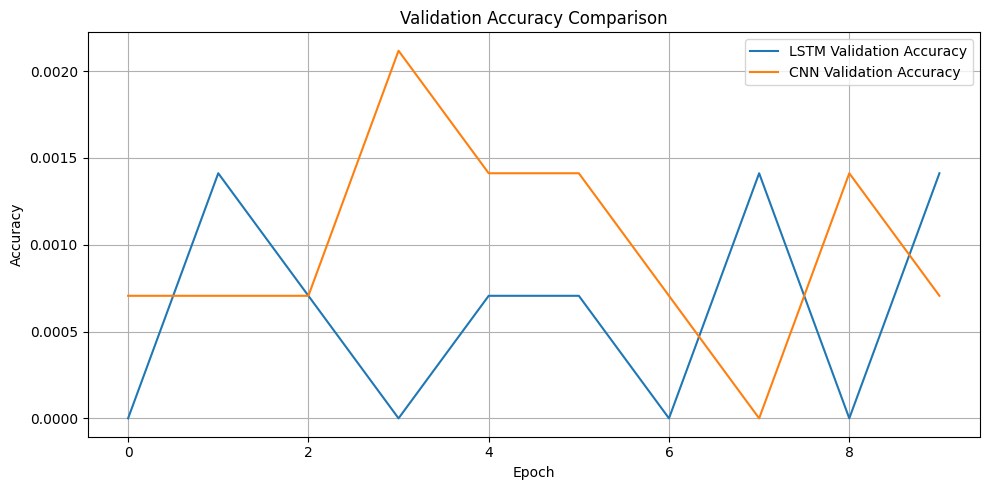

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history_lstm.history['val_accuracy'], label='LSTM Validation Accuracy')
#plt.plot(history_lstm2.history['val_accuracy'], label='LSTM Validation Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='CNN Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Visualisations

#Formations detected by deeplearning model

In [ ]:
predicted_probabilities = model_lstm.predict(X_form)
predicted_formation_classes = np.argmax(predicted_probabilities, axis=1)

222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
predicted_positions = model_lstm2.predict(X)
predicted_positions_df = pd.DataFrame(predicted_positions, columns=['predicted_start_x', 'predicted_start_y'])

20099/20099 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step


In [ ]:
decoded_labels = label_encoder.inverse_transform(predicted_formation_classes)
formation_data['predicted_label'] = decoded_labels
formation_data['predicted_teamId'] = formation_data['predicted_label'].apply(lambda x: x.split('_')[0])
formation_data['predicted_matchId'] = formation_data['predicted_label'].apply(lambda x: x.split('_')[1])
formation_data = pd.concat([formation_data, predicted_positions_df], axis=1)
display(formation_data.head())

match_label team_label  player_label  start_x  start_y           label  \
0     Match_1     Team_1           1.0     56.4     65.2  Team_1_Match_1   
1     Match_1     Team_1           2.0     73.8     65.2  Team_1_Match_1   
2     Match_1     Team_1           3.0     41.4     53.2  Team_1_Match_1   
3     Match_1     Team_1           7.0      4.8     42.4  Team_1_Match_1   
4     Match_1     Team_1           8.0     60.9     37.0  Team_1_Match_1   

   formation_class    predicted_label predicted_teamId predicted_matchId  \
0            380.0   Team_8_Match_323             Team                 8   
1            380.0   Team_2_Match_107             Team                 2   
2            380.0   Team_8_Match_323             Team                 8   
3            380.0  Team_10_Match_140             Team                10   
4            380.0  Team_13_Match_105             Team                13   

   predicted_start_x  predicted_start_y  
0                NaN                NaN  
1                NaN                NaN  
2                NaN                NaN  
3                NaN                NaN  
4                NaN                NaN

In [ ]:
# Define formation_df to include team_label and player_label for merging
formation_df = EvEngn.groupby(['matchId', 'teamId', 'matchPeriod', 'playerId', 'team_label', 'player_label'])[['start_x', 'start_y']].mean().reset_index()
formation_df['match_label'] = formation_df['matchId'].map(match_labels)

formation_viz_data = pd.merge(formation_df, formation_data[['match_label', 'team_label', 'player_label', 'predicted_label', 'predicted_teamId', 'predicted_matchId']],
                              on=['match_label', 'team_label', 'player_label'],
                              how='left')
display(formation_viz_data.head())

matchId  teamId matchPeriod  playerId team_label  player_label    start_x  \
0  2499719    1609          1H         0     Team_1             1  51.552000   
1  2499719    1609          1H      3319     Team_1             2  73.622222   
2  2499719    1609          1H      3560     Team_1             3  43.322449   
3  2499719    1609          1H      7868     Team_1             4  73.407692   
4  2499719    1609          1H      7882     Team_1             7   5.142857   

     start_y match_label    predicted_label predicted_teamId predicted_matchId  
0  47.936000     Match_1   Team_8_Match_323             Team                 8  
1  37.614815     Match_1   Team_2_Match_107             Team                 2  
2  37.681633     Match_1   Team_8_Match_323             Team                 8  
3  13.461538     Match_1                NaN              NaN               NaN  
4  18.342857     Match_1  Team_10_Match_140             Team                10

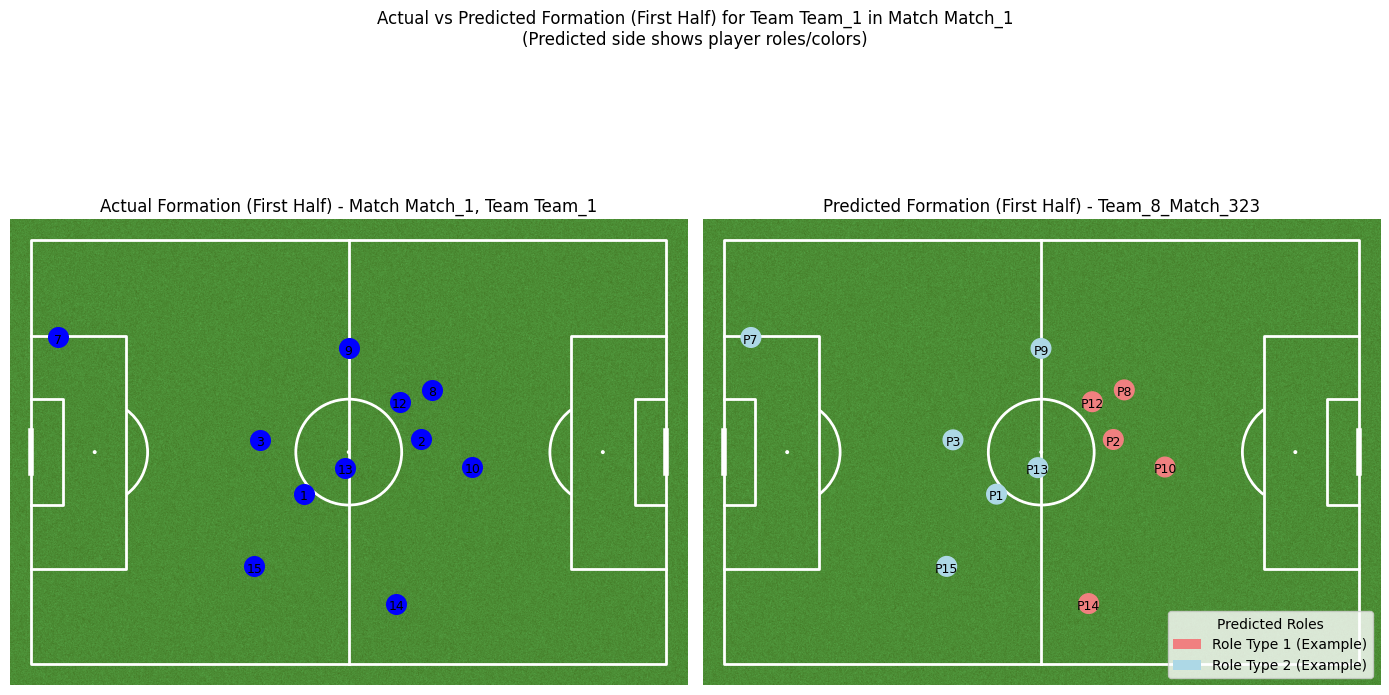

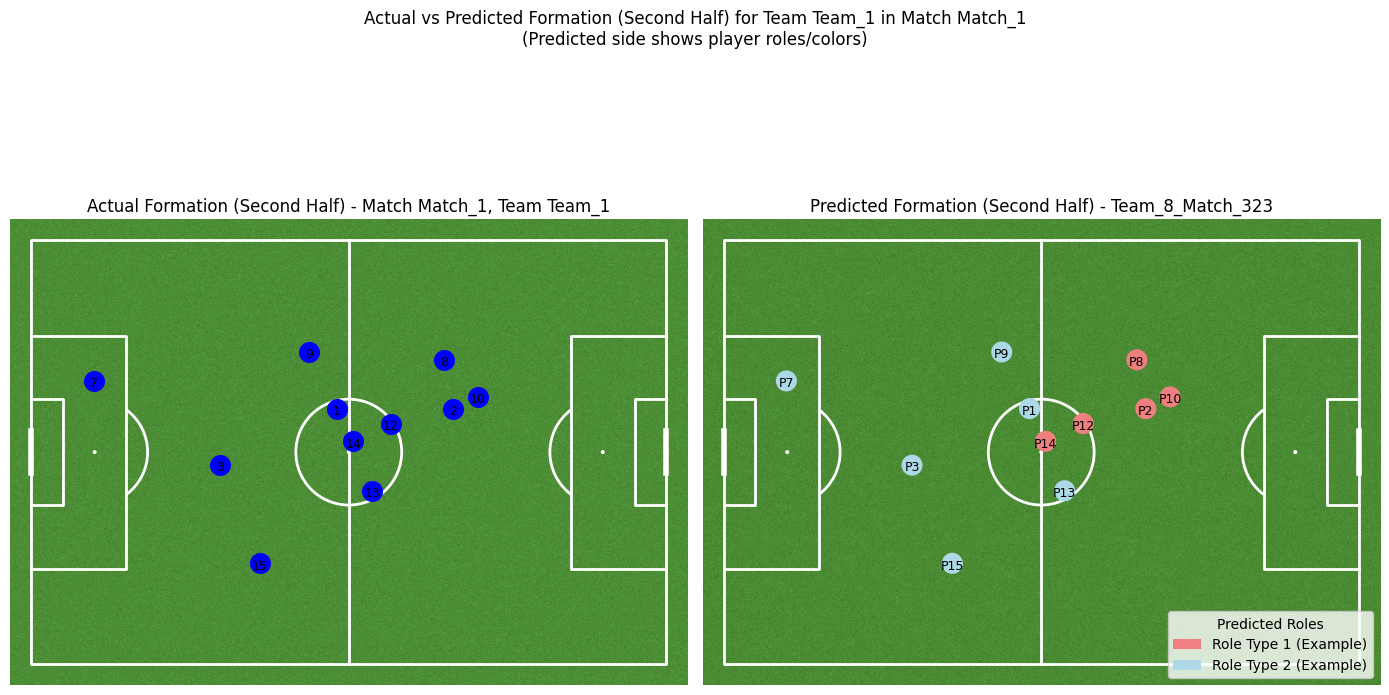

In [ ]:
# Function to map player labels to predicted roles (simplified example)
# In a real scenario, this would involve more complex logic or another model
# to assign tactical roles (e.g., GK, RB, CB, CM, ST) based on positions
# and the predicted formation.
def get_predicted_role(player_label, predicted_formation_label):
    # This is a placeholder. You would need a mapping based on actual formations
    # and average positions for that formation.
    # For this example, we'll just use player label as a proxy or leave it as is
    return f"P{int(player_label)}"

# Select a specific match and team to visualize (using the same ones as before)
match_id_to_visualize = formation_viz_data['match_label'].unique()[0]
team_id_to_visualize = formation_viz_data[formation_viz_data['match_label'] == match_id_to_visualize]['team_label'].unique()[0]

# Filter data for the selected match and team, and drop rows with missing predicted labels
team_match_viz_data = formation_viz_data[(formation_viz_data['match_label'] == match_id_to_visualize) &
                                         (formation_viz_data['team_label'] == team_id_to_visualize)].dropna(subset=['predicted_label']).copy()

# Filter data to include only players who played in the first half
team_match_viz_data_1h = team_match_viz_data[team_match_viz_data['matchPeriod'] == '1H'].copy()

if team_match_viz_data_1h.empty:
    print(f"No data with predicted formation labels found for the first half of Match {match_id_to_visualize}, Team {team_id_to_visualize}. Please check the data and predictions.")
else:
    # Get the predicted formation label for the selected team and match (using 1H data)
    predicted_formation_label = team_match_viz_data_1h['predicted_label'].iloc[0]

    # Create a Pitch object
    pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')

    # Create a figure with two subplots for comparison
    fig, axes = pitch.draw(nrows=1, ncols=2, figsize=(14, 8))
    ax_actual = axes[0]
    ax_predicted = axes[1]

    # Plot the actual formation on the left subplot (using 1H data)
    scatter_actual = pitch.scatter(team_match_viz_data_1h['start_x'], team_match_viz_data_1h['start_y'],
                                   s=200, color='blue', ax=ax_actual)

    # Annotate player IDs on the actual formation plot (using 1H data)
    for _, row in team_match_viz_data_1h.iterrows():
        ax_actual.text(row['start_x'], row['start_y'] + 1, str(int(row['player_label'])),
                       ha='center', fontsize=9, color='black')

    ax_actual.set_title(f"Actual Formation (First Half) - Match {match_id_to_visualize}, Team {team_id_to_visualize}")


    # Plot the predicted formation on the right subplot, now with color-coding/labeling by role
    # For this example, we'll use player_label as a simple label, but you could color-code here.
    # To color-code, you would need a 'predicted_role' column and a color mapping.
    # Let's demonstrate labeling with the predicted role (using the simple function above)

    # Assign a dummy 'predicted_role' for demonstration. In a real scenario, this would be predicted.
    # For now, we'll just use the player label prefixed with 'P' as a placeholder for a role label.
    team_match_viz_data_1h['predicted_role'] = team_match_viz_data_1h['player_label'].apply(lambda x: f"P{int(x)}")

    # Example of simple color mapping based on a dummy role (e.g., even/odd player labels)
    # In a real case, map to GK, DEF, MID, FWD colors.
    def get_role_color(player_label):
        if int(player_label) % 2 == 0:
            return 'lightcoral' # Example color 1
        else:
            return 'lightblue' # Example color 2

    # Get colors based on player labels for the predicted plot
    colors = team_match_viz_data_1h['player_label'].apply(get_role_color).tolist()


    # Scatter plot with colors based on predicted role (using dummy color logic)
    scatter_predicted = pitch.scatter(team_match_viz_data_1h['start_x'], team_match_viz_data_1h['start_y'],
                                      s=200, color=colors, ax=ax_predicted)

    # Annotate predicted roles on the predicted formation plot
    for _, row in team_match_viz_data_1h.iterrows():
        ax_predicted.text(row['start_x'], row['start_y'] + 1, row['predicted_role'], # Use predicted_role for label
                          ha='center', fontsize=9, color='black') # You might want a different text color


    ax_predicted.set_title(f"Predicted Formation (First Half) - {predicted_formation_label}")

    plt.suptitle(f"Actual vs Predicted Formation (First Half) for Team {team_id_to_visualize} in Match {match_id_to_visualize}\n(Predicted side shows player roles/colors)", y=1.02)
    plt.tight_layout()

    # Add a legend for the colors if you implement a meaningful color mapping
    # This requires creating proxy artists for the legend.
    # Example (assuming two colors based on dummy role):
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='lightcoral', label='Role Type 1 (Example)'),
                       Patch(facecolor='lightblue', label='Role Type 2 (Example)')]
    ax_predicted.legend(handles=legend_elements, loc='lower right', title="Predicted Roles")


    plt.show()

# Repeat for the second half if needed, applying the same logic for coloring/labeling the predicted side
# Select the same match and team to visualize
match_id_to_visualize = formation_viz_data['match_label'].unique()[0]
team_id_to_visualize = formation_viz_data[formation_viz_data['match_label'] == match_id_to_visualize]['team_label'].unique()[0]

# Filter data for the selected match and team, and drop rows with missing predicted labels
team_match_viz_data = formation_viz_data[(formation_viz_data['match_label'] == match_id_to_visualize) &
                                         (formation_viz_data['team_label'] == team_id_to_visualize)].dropna(subset=['predicted_label']).copy()

# Filter data to include only players who played in the second half
team_match_viz_data_2h = team_match_viz_data[team_match_viz_data['matchPeriod'] == '2H'].copy()


if team_match_viz_data_2h.empty:
    print(f"No data with predicted formation labels found for the second half of Match {match_id_to_visualize}, Team {team_id_to_visualize}. Please check the data and predictions.")
else:
    # Get the predicted formation label for the selected team and match (using 2H data)
    predicted_formation_label = team_match_viz_data_2h['predicted_label'].iloc[0]

    # Create a Pitch object
    pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')

    # Create a figure with two subplots for comparison
    fig, axes = pitch.draw(nrows=1, ncols=2, figsize=(14, 8))
    ax_actual = axes[0]
    ax_predicted = axes[1]

    # Plot the actual formation on the left subplot (using 2H data)
    scatter_actual = pitch.scatter(team_match_viz_data_2h['start_x'], team_match_viz_data_2h['start_y'],
                                   s=200, color='blue', ax=ax_actual)

    # Annotate player IDs on the actual formation plot (using 2H data)
    for _, row in team_match_viz_data_2h.iterrows():
        ax_actual.text(row['start_x'], row['start_y'] + 1, str(int(row['player_label'])),
                       ha='center', fontsize=9, color='black')

    ax_actual.set_title(f"Actual Formation (Second Half) - Match {match_id_to_visualize}, Team {team_id_to_visualize}")


    # Plot the predicted formation on the right subplot, now with color-coding/labeling by role
    # Assign a dummy 'predicted_role' for demonstration, similar to the first half
    team_match_viz_data_2h['predicted_role'] = team_match_viz_data_2h['player_label'].apply(lambda x: f"P{int(x)}")

    # Get colors based on player labels for the predicted plot (using dummy color logic)
    colors = team_match_viz_data_2h['player_label'].apply(get_role_color).tolist() # Re-using the same color function

    # Scatter plot with colors based on predicted role
    scatter_predicted = pitch.scatter(team_match_viz_data_2h['start_x'], team_match_viz_data_2h['start_y'],
                                      s=200, color=colors, ax=ax_predicted)

    # Annotate predicted roles on the predicted formation plot
    for _, row in team_match_viz_data_2h.iterrows():
        ax_predicted.text(row['start_x'], row['start_y'] + 1, row['predicted_role'], # Use predicted_role for label
                          ha='center', fontsize=9, color='black')


    ax_predicted.set_title(f"Predicted Formation (Second Half) - {predicted_formation_label}")

    plt.suptitle(f"Actual vs Predicted Formation (Second Half) for Team {team_id_to_visualize} in Match {match_id_to_visualize}\n(Predicted side shows player roles/colors)", y=1.02)
    plt.tight_layout()

    # Add a legend for the colors if you implement a meaningful color mapping
    legend_elements = [Patch(facecolor='lightcoral', label='Role Type 1 (Example)'),
                       Patch(facecolor='lightblue', label='Role Type 2 (Example)')]
    ax_predicted.legend(handles=legend_elements, loc='lower right', title="Predicted Roles")


    plt.show()



Animation saved as formation_shift_match_Match_1_team_Team_1.gif


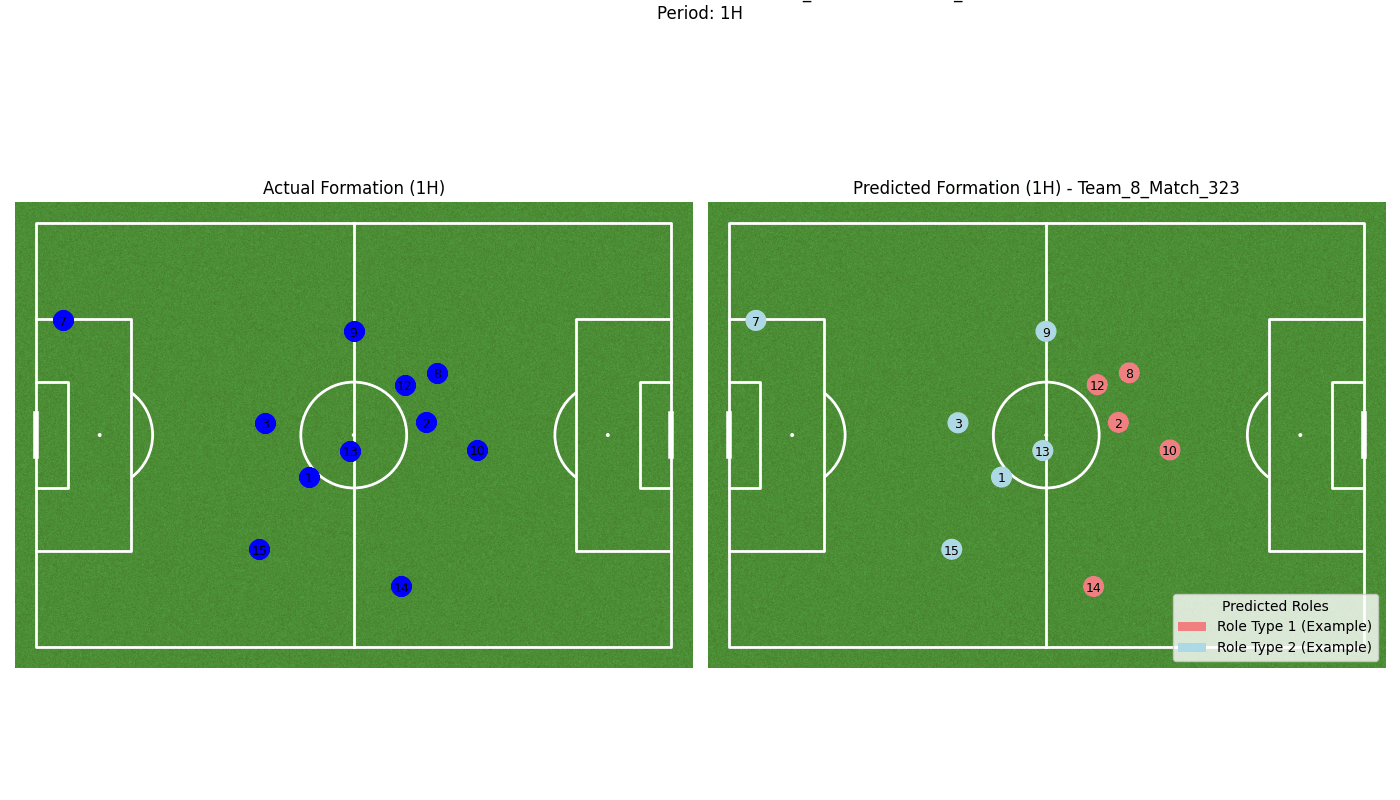

In [ ]:
# Create an animated GIF showing the formation shifts over time

# Filter data for the selected match and team
team_match_animation_data = formation_viz_data[(formation_viz_data['match_label'] == match_id_to_visualize) &
                                                 (formation_viz_data['team_label'] == team_id_to_visualize)].dropna(subset=['predicted_label']).copy()

if team_match_animation_data.empty:
    print(f"No data with predicted formation labels found for animation for Match {match_id_to_visualize}, Team {team_id_to_visualize}. Please check the data and predictions.")
else:
    # Get unique match periods and sort them (e.g., 1H, 2H)
    match_periods = sorted(team_match_animation_data['matchPeriod'].unique())

    # Create a Pitch object
    pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')

    # Create a figure with two subplots for comparison
    fig, axes = pitch.draw(nrows=1, ncols=2, figsize=(14, 8))
    ax_actual = axes[0]
    ax_predicted = axes[1]

    # Function to update the plot for each frame
    def update(frame):
        ax_actual.clear()
        ax_predicted.clear()
        pitch.draw(ax=ax_actual)
        pitch.draw(ax=ax_predicted)

        current_period = match_periods[frame]
        period_data = team_match_animation_data[team_match_animation_data['matchPeriod'] == current_period]

        if not period_data.empty:
            # Actual formation
            scatter_actual = pitch.scatter(period_data['start_x'], period_data['start_y'],
                                           s=200, color='blue', ax=ax_actual)
            for _, row in period_data.iterrows():
                ax_actual.text(row['start_x'], row['start_y'] + 1, str(int(row['player_label'])),
                               ha='center', fontsize=9, color='black')
            ax_actual.set_title(f"Actual Formation ({current_period})")

            # Predicted formation
            predicted_formation_label = period_data['predicted_label'].iloc[0] # Assuming predicted label is same for all players in the period

            # Get colors based on player labels for the predicted plot (using dummy color logic)
            colors = period_data['player_label'].apply(get_role_color).tolist() # Re-using the same color function

            scatter_predicted = pitch.scatter(period_data['start_x'], period_data['start_y'],
                                              s=200, color=colors, ax=ax_predicted)
            for _, row in period_data.iterrows():
                ax_predicted.text(row['start_x'], row['start_y'] + 1, str(int(row['player_label'])),
                                  ha='center', fontsize=9, color='black')
            ax_predicted.set_title(f"Predicted Formation ({current_period}) - {predicted_formation_label}")

            # Add a legend for the colors if you implement a meaningful color mapping
            from matplotlib.patches import Patch
            legend_elements = [Patch(facecolor='lightcoral', label='Role Type 1 (Example)'),
                               Patch(facecolor='lightblue', label='Role Type 2 (Example)')]
            ax_predicted.legend(handles=legend_elements, loc='lower right', title="Predicted Roles")

        fig.suptitle(f"Actual vs Predicted Formation for Team {team_id_to_visualize} in Match {match_id_to_visualize}\nPeriod: {current_period}", y=1.02)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
        return scatter_actual, scatter_predicted

    # Create the animation
    ani = animation.FuncAnimation(fig, update, frames=len(match_periods), blit=False, repeat=True, interval=2000) # Adjust interval for speed

    # Save the animation as a GIF
    gif_filename = f'formation_shift_match_{match_id_to_visualize}_team_{team_id_to_visualize}.gif'
    ani.save(gif_filename, writer='pillow', fps=1) # Adjust fps for speed
    print(f"Animation saved as {gif_filename}")

    # Close the plot after saving
    plt.close(fig)

    # Display the GIF in Colab (requires IPython display)
    try:
        from IPython.display import Image
        display(Image(open(gif_filename,'rb').read()))
    except ImportError:
        print("IPython not available, cannot display GIF directly.")

## Analyzing Average Player Positions and Participation by Half

In [ ]:
# Select a specific match and team to analyze
selected_match_id = formation_df['match_label'].unique()[0] # Example: First match in the data
selected_team_id = formation_df['team_label'].unique()[0] # Example: First team in the data

print(f"Analyzing Match: {selected_match_id}, Team: {selected_team_id}\n")

# Filter formation data for the selected match and team
team_match_formation_data = formation_df[(formation_df['match_label'] == selected_match_id) &
                                         (formation_df['team_label'] == selected_team_id)].copy()

# Display average positions for each half
print("Average Player Positions (First Half):")
display(team_match_formation_data[team_match_formation_data['matchPeriod'] == '1H'][['player_label', 'start_x', 'start_y']])

print("\nAverage Player Positions (Second Half):")
display(team_match_formation_data[team_match_formation_data['matchPeriod'] == '2H'][['player_label', 'start_x', 'start_y']])

# Identify players who played in each half
players_1h = team_match_formation_data[team_match_formation_data['matchPeriod'] == '1H']['player_label'].unique()
players_2h = team_match_formation_data[team_match_formation_data['matchPeriod'] == '2H']['player_label'].unique()

print(f"\nPlayers who played in the First Half ({selected_match_id}, Team {selected_team_id}):")
print(players_1h)

print(f"\nPlayers who played in the Second Half ({selected_match_id}, Team {selected_team_id}):")
print(players_2h)

# Identify players who played in BOTH halves
players_both_halves = np.intersect1d(players_1h, players_2h)
print(f"\nPlayers who played in Both Halves ({selected_match_id}, Team {selected_team_id}):")
print(players_both_halves)

# Identify players who only played in the first half
players_only_1h = np.setdiff1d(players_1h, players_2h)
print(f"\nPlayers who only played in the First Half ({selected_match_id}, Team {selected_team_id}):")
print(players_only_1h)

# Identify players who only played in the second half
players_only_2h = np.setdiff1d(players_2h, players_1h)
print(f"\nPlayers who only played in the Second Half ({selected_match_id}, Team {selected_team_id}):")
print(players_only_2h)

Analyzing Match: Match_1, Team: Team_1

Average Player Positions (First Half):


player_label    start_x    start_y
0              1  51.552000  47.936000
1              2  73.622222  37.614815
2              3  43.322449  37.681633
3              4  73.407692  13.461538
4              7   5.142857  18.342857
5              8  75.692308  28.246154
6              9  59.952941  20.407843
7             10  83.376000  42.816000
8             12  69.635821  30.483582
9             13  59.352381  42.933333
10            14  68.950000  68.616667
11            15  42.142373  61.586441


Average Player Positions (Second Half):


player_label    start_x    start_y
12             1  57.794595  31.783784
13             2  79.755556  31.807407
14             3  35.588571  42.468571
15             4  56.824615  44.923077
16             5  73.690909  40.545455
17             6  69.600000  66.880000
18             7  11.850000  26.550000
19             8  78.060000  22.560000
20             9  52.536000  21.088000
21            10  84.342857  29.571429
22            11  76.160000  40.160000
23            12  67.941818  34.603636
24            13  64.416000  47.296000
25            14  60.826667  37.955556
26            15  43.200000  61.007407


Players who played in the First Half (Match_1, Team Team_1):
[ 1  2  3  4  7  8  9 10 12 13 14 15]

Players who played in the Second Half (Match_1, Team Team_1):
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]

Players who played in Both Halves (Match_1, Team Team_1):
[ 1  2  3  4  7  8  9 10 12 13 14 15]

Players who only played in the First Half (Match_1, Team Team_1):
[]

Players who only played in the Second Half (Match_1, Team Team_1):
[ 5  6 11]


In [ ]:
def get_position_label(x, y):
    if x < 15:
        return 'GK'
    elif x < 60:
        return 'DEF'
    elif x < 70:
        return 'MID'
    else:
        return 'ATT'

team_match_formation_data['position_label'] = team_match_formation_data.apply(lambda row: get_position_label(row['start_x'], row['start_y']), axis=1)

print("Player positions for the first half:")
display(team_match_formation_data[team_match_formation_data['matchPeriod'] == '1H'][['player_label', 'position_label']])

print("\nPlayer positions for the second half:")
display(team_match_formation_data[team_match_formation_data['matchPeriod'] == '2H'][['player_label', 'position_label']])

Player positions for the first half:


player_label position_label
0              1            DEF
1              2            ATT
2              3            DEF
3              4            ATT
4              7             GK
5              8            ATT
6              9            DEF
7             10            ATT
8             12            MID
9             13            DEF
10            14            MID
11            15            DEF


Player positions for the second half:


player_label position_label
12             1            DEF
13             2            ATT
14             3            DEF
15             4            DEF
16             5            ATT
17             6            MID
18             7             GK
19             8            ATT
20             9            DEF
21            10            ATT
22            11            ATT
23            12            MID
24            13            MID
25            14            MID
26            15            DEF

Animation saved as formation_shift_with_roles_match_Match_1_team_Team_1.gif


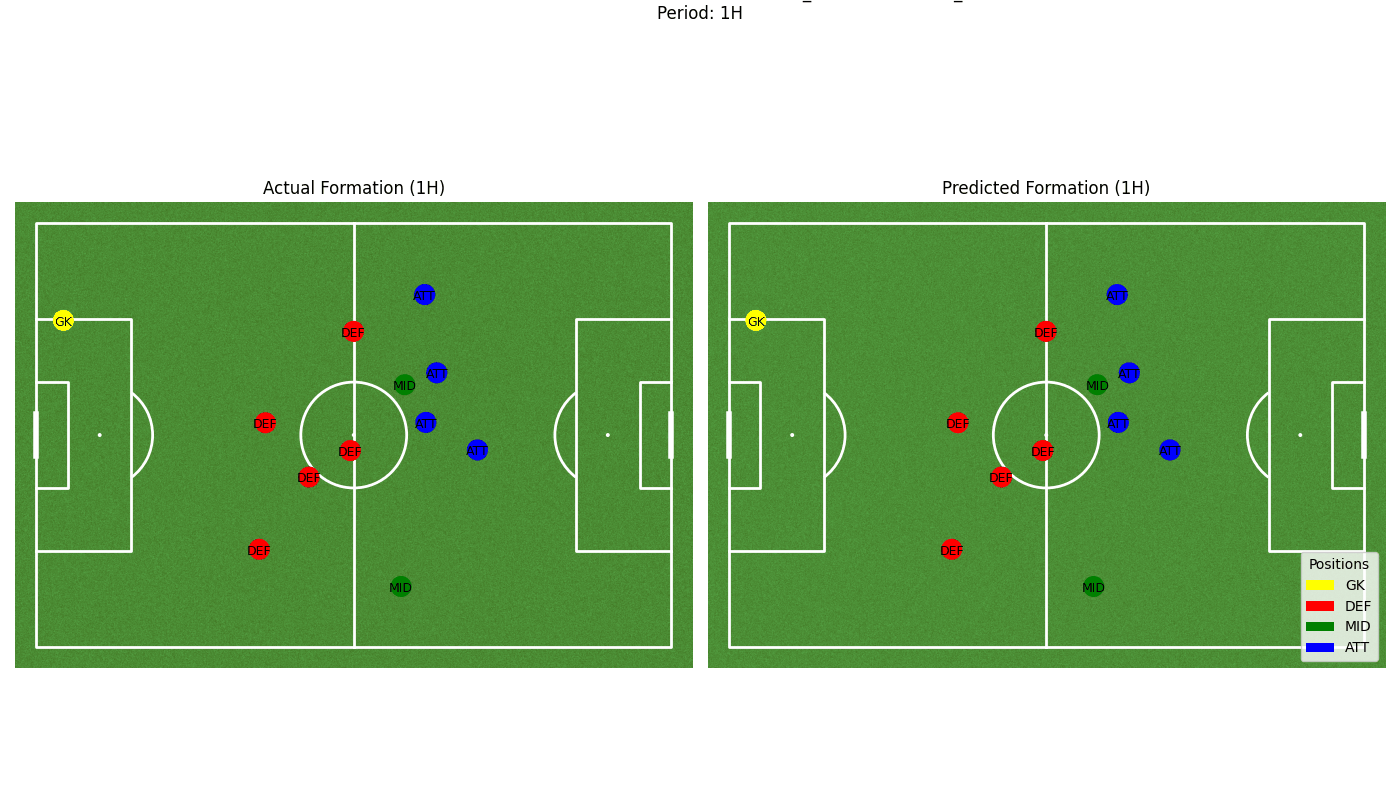

In [ ]:
# Create an animated GIF showing the formation shifts over time with position labels

# Get unique match periods and sort them (e.g., 1H, 2H)
match_periods = sorted(team_match_formation_data['matchPeriod'].unique())

# Create a Pitch object
pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')

# Create a figure with two subplots for comparison
fig, axes = pitch.draw(nrows=1, ncols=2, figsize=(14, 8))
ax_actual = axes[0]
ax_predicted = axes[1]

# Function to get color based on position label
def get_position_color(position_label):
    if position_label == 'GK':
        return 'yellow'
    elif position_label == 'DEF':
        return 'red'
    elif position_label == 'MID':
        return 'green'
    else: # ATT
        return 'blue'

# Function to update the plot for each frame
def update(frame):
    ax_actual.clear()
    ax_predicted.clear()
    pitch.draw(ax=ax_actual)
    pitch.draw(ax=ax_predicted)

    current_period = match_periods[frame]
    period_data = team_match_formation_data[team_match_formation_data['matchPeriod'] == current_period]

    if not period_data.empty:
        # Actual formation with position labels
        colors = period_data['position_label'].apply(get_position_color).tolist()
        scatter_actual = pitch.scatter(period_data['start_x'], period_data['start_y'],
                                       s=200, color=colors, ax=ax_actual)
        for _, row in period_data.iterrows():
            ax_actual.text(row['start_x'], row['start_y'] + 1, row['position_label'],
                           ha='center', fontsize=9, color='black')
        ax_actual.set_title(f"Actual Formation ({current_period})")

        # Predicted formation (using the same data for now, but can be replaced with a model's output)
        scatter_predicted = pitch.scatter(period_data['start_x'], period_data['start_y'],
                                          s=200, color=colors, ax=ax_predicted)
        for _, row in period_data.iterrows():
            ax_predicted.text(row['start_x'], row['start_y'] + 1, row['position_label'],
                              ha='center', fontsize=9, color='black')
        ax_predicted.set_title(f"Predicted Formation ({current_period})")

        # Add a legend for the colors
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='yellow', label='GK'),
                           Patch(facecolor='red', label='DEF'),
                           Patch(facecolor='green', label='MID'),
                           Patch(facecolor='blue', label='ATT')]
        ax_predicted.legend(handles=legend_elements, loc='lower right', title="Positions")

    fig.suptitle(f"Actual vs Predicted Formation for Team {selected_team_id} in Match {selected_match_id}\nPeriod: {current_period}", y=1.02)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
    return scatter_actual, scatter_predicted

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(match_periods), blit=False, repeat=True, interval=2000) # Adjust interval for speed

# Save the animation as a GIF
gif_filename = f'formation_shift_with_roles_match_{selected_match_id}_team_{selected_team_id}.gif'
ani.save(gif_filename, writer='pillow', fps=1) # Adjust fps for speed
print(f"Animation saved as {gif_filename}")

# Close the plot after saving
plt.close(fig)

# Display the GIF in Colab (requires IPython display)
try:
    from IPython.display import Image
    display(Image(open(gif_filename,'rb').read()))
except ImportError:
    print("IPython not available, cannot display GIF directly.")